In [1]:
import os
import zarr
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from eval import get_distances, EvalDataset, CollateFnPairs
from tokenizer import SpTokenizer
from model import FineTunedModel

In [2]:
ntokens = SpTokenizer.get_vocab_size()
emsize = 512
d_hid = 2048
d_out = 512
nlayers = 6
nhead = 8
dropout = 0.1
use_layer_norm = True
model = FineTunedModel(
    ntokens,
    emsize,
    d_out,
    nhead,
    d_hid,
    nlayers,
    dropout=dropout,
    use_layer_norm=use_layer_norm
).cuda()
model_checkpoint = torch.load(
    "best_checkpoints/fine_tuning/sp_512_emb/simclr/512/checkpoint-1-val_loss-1.7193-val_acc-0.7966"
)
weights = {
    k[10:] if k.startswith("_orig_mod") else k: v
    for k, v in model_checkpoint["model_state_dict"].items()
}
model.load_state_dict(weights)
model.eval()
model_data = EvalDataset(os.path.join("data", "gcj_dataset_512", "test.zarr"))

In [3]:
with torch.inference_mode():
    distances = get_distances(
        model,
        model_data,
        lambda x, y: 1 - F.cosine_similarity(x, y),
        CollateFnPairs(0),
    )

c:\Users\david\Documents\Universidad\M1\TFM\CLAVE\transformer.py:58: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\NestedTensorImpl.cpp:179.)
  output = torch._nested_tensor_from_mask(
c:\Users\david\miniconda3\envs\tfm-torch\Lib\site-packages\torch\nn\modules\transformer.py:685: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._transformer_encoder_layer_fwd(


Computed distances


In [16]:
def draw_hist(distances, fig_name):
    same_author = [distance for distance, is_same in distances if is_same]
    different_author = [distance for distance, is_same in distances if not is_same]

    _, ax = plt.subplots(figsize=(4, 3))
    ax.hist(same_author, label="Same author", bins=50, alpha=0.5)
    ax.hist(different_author, label="Different author", bins=50, alpha=0.5)
    ax.legend(loc="upper right")
    plt.ylabel("Number of pairs")
    plt.xlabel("Cosine distance")
    plt.tight_layout()
    plt.savefig(os.path.join("..", "paper", "figures", f"{fig_name}.svg"), format="svg")
    plt.show()

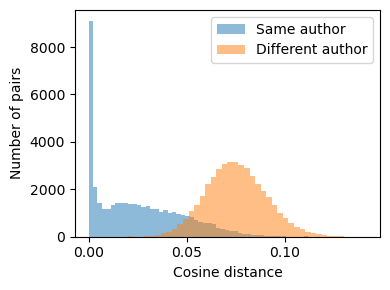

In [17]:
draw_hist(distances, "histogram")

In [3]:
random_model = FineTunedModel(
    ntokens,
    emsize,
    d_out,
    nhead,
    d_hid,
    nlayers,
    dropout=dropout,
    use_layer_norm=use_layer_norm,
).cuda()
_ = random_model.eval()

In [75]:
with torch.inference_mode():
    random_distances = get_distances(
        random_model,
        model_data,
        lambda x, y: 1 - F.cosine_similarity(x, y),
        CollateFnPairs(0),
    )

Computed distances


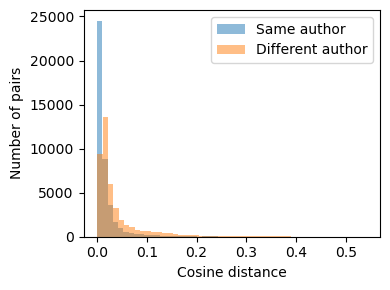

In [93]:
draw_hist(random_distances, "histogram_random")

In [4]:
from config import PRETRAINING_CHECKPOINT


pretraining_checkpoint = torch.load(PRETRAINING_CHECKPOINT)
pretrained_weights = {
    k[8 if k.startswith("e") else 18:]: v
    for k, v in pretraining_checkpoint["model_state_dict"].items()
    if k.startswith("encoder.") or k.startswith("_orig_mod.encoder.")
}

pretrained_model = FineTunedModel(
    ntokens,
    emsize,
    d_out,
    nhead,
    d_hid,
    nlayers,
    dropout=dropout,
    use_layer_norm=use_layer_norm,
    pretrained_weights=pretrained_weights
).cuda()
_ = pretrained_model.eval()

In [101]:
with torch.inference_mode():
    pretrained_distances = get_distances(
        pretrained_model,
        model_data,
        lambda x, y: 1 - F.cosine_similarity(x, y),
        CollateFnPairs(0),
    )

Computed distances


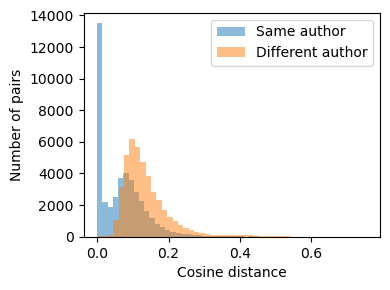

In [102]:
draw_hist(pretrained_distances, "histogram_pretrained")

In [5]:
import json


with open(
    os.path.join("data", "gcj_dataset_512", "user_submission_idxs_test_no_pairs.json"),
    "r",
    encoding="UTF-8",
) as f:
    user_submissions_idxs = json.load(f)

In [31]:
import random


candidates = []
for author, solutions in user_submissions_idxs.items():
    if len(solutions) >= 10:
        candidates.append(author)

for_clusters = {
    author: [idxs[0] for _, idxs in random.sample(user_submissions_idxs[author], 10)]
    for author in random.sample(candidates, 15)
}

In [19]:
import numpy as np
from sklearn.manifold import TSNE


tsne = TSNE()
marker_types = [
    "o",
    "v",
    "^",
    "<",
    ">",
    "s",
    "p",
    "P",
    "*",
    "X",
    "8",
    "h",
    "d",
    "D",
    "H",
]
colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
    "#ff33cc",
    "#33ffcc",
    "#cc33ff",
    "#ffcc33",
    "#33ccff",
]


def draw_clusters(model, data, out_size, fig_name):
    n_by_author = len(list(for_clusters.values())[0])
    embeddings = np.zeros((len(for_clusters) * n_by_author, out_size))
    with torch.inference_mode():
        i = 0
        for _, solutions in for_clusters.items():
            for solution in solutions:
                input = torch.unsqueeze(torch.tensor(data[solution]), 0).cuda()
                embeddings[i] = model(input).cpu().numpy()
                i += 1

    embeddings_2d = tsne.fit_transform(embeddings)

    for i in range(len(for_clusters)):
        plt.scatter(
            embeddings_2d[i * n_by_author : (i + 1) * n_by_author, 0],
            embeddings_2d[i * n_by_author : (i + 1) * n_by_author, 1],
            c=colors[i],
            marker=marker_types[i],
        )
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig(os.path.join("..", "paper", "figures", f"{fig_name}.svg"), format="svg")
    plt.show()

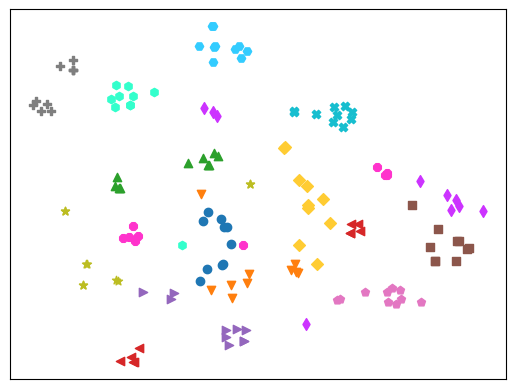

In [32]:
draw_clusters(
    model,
    zarr.open_array(os.path.join("data", "gcj_dataset_512", "test_no_pairs.zarr")),
    512,
    "clusters",
)

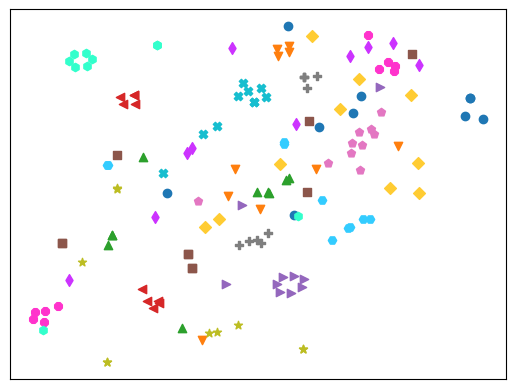

In [33]:
draw_clusters(
    random_model,
    zarr.open_array(os.path.join("data", "gcj_dataset_512", "test_no_pairs.zarr")),
    512,
    "clusters_random",
)

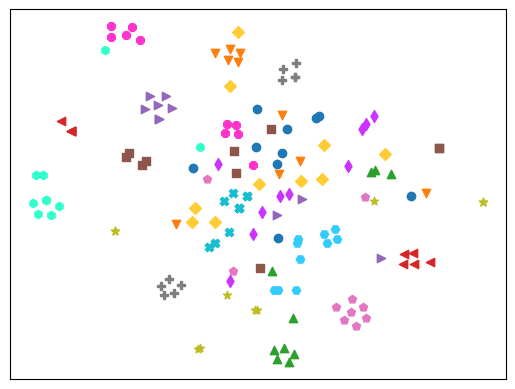

In [34]:
draw_clusters(
    pretrained_model,
    zarr.open_array(os.path.join("data", "gcj_dataset_512", "test_no_pairs.zarr")),
    512,
    "clusters_pretrained",
)

In [26]:
import sqlite3
from gcj_data_loader import get_partition_data, DATASET_PATH


tokenizer = SpTokenizer()
partitions = [get_partition_data(part) for part in ["train", "val", "test"]]
lengths = []
cons = {
    archive: sqlite3.connect(os.path.join(DATASET_PATH, "solutions", archive))
    for archive in os.listdir(os.path.join(DATASET_PATH, "solutions"))
}


for partition in partitions:
    for user, archive, solution in partition:
        con = cons[archive]
        cur = con.cursor()
        res = cur.execute(f"SELECT data FROM sqlar WHERE name = '{solution}' LIMIT 1")
        program = res.fetchone()[0]
        cur.close()
        try:
            tokens = tokenizer.tokenizes(program.decode())
            lengths.append(len(tokens))
        except Exception:
            pass

In [33]:
lengths = np.array(lengths)
lengths_log = np.log(lengths)

mean_log_data = np.mean(lengths_log)
std_log_data = np.std(lengths_log)
z_scores = (lengths_log - mean_log_data) / std_log_data

outliers_log = np.abs(z_scores) > 3

filtered_lengths_log = lengths_log[~outliers_log]
filtered_lengths = np.exp(filtered_lengths_log)

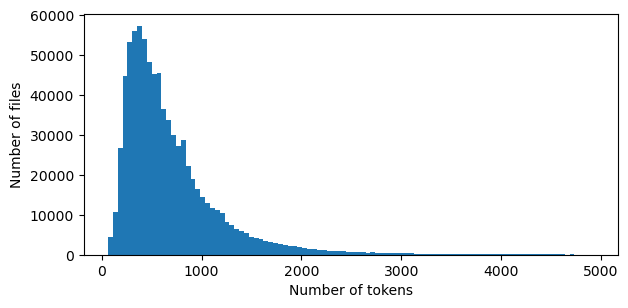

In [46]:
plt.hist(filtered_lengths, bins=100)
plt.ylabel("Number of files")
plt.xlabel("Number of tokens")
plt.gca().set_aspect(0.04)
plt.savefig(os.path.join("..", "paper", "figures", "numer_of_tokens.svg"), format="svg")
plt.show()